# EP2 - Fractal de Mandelbrot utilizando CUDA e OpenMPI

Grupo:

| Nome | NUSP |
|------|------|
| Carlos Eduardo Leal de Castro | 11921804 |
| Felipe de Lima Peressim | 11823558 |
| José Luiz Maciel Pimenta | 11896720 |
| Luis Ricardo Manrique | 5779294 |
| Rafael Fernandes Alencar | 9344730 |



## Sumário
* Configurando o ambiente
* Introdução - Conjunto de Mandelbrot
* Definindo funções e Plots
* Algoritmos: OpenMPI, CUDA
* Experimentos
* Montando DataFrames
* Melhores e Piores Desempenhos
* Número de Threads
* Número de Processos
* Dimensões dos blocos

## Introdução <a class="anchor" id="third-bullet"></a>

O objetivo deste trabalho é gerar o Conjunto de Mandelbrot a partir de abordagens diferentes: método **sequencial**, método paralelo usando a ferramenta **Pthreads**, método paralelo usando a ferramenta **OpenMP**, o método paralelo usando a ferramenta **OpenMPI** e método utilizando **CUDA**. Além desses, analisamos a construção do Conjunto de Mandelbrot utilizando alguns desses métodos juntos, como **OpenMPI+OpenMP** e **CUDA+OpenMPI**.

## Configurando o ambiente <a class="anchor" id="config-bullet"></a>

Os pacotes necessários para executar os comandos deste notebook serão atualizados na célula seguinte:

In [24]:
] up

In [23]:
using DataFrames, Query, StatsPlots, Statistics, CSV, Measures

## Definindo funções e plots <a class="anchor" id="functions-bullet"></a>

As funções `save_csv_results` e `read_csv_results`, que salva um *Dataframe* dado em um arquivo *.csv*  e lê um arquivo *.csv* e o armazena em uma *Dataframe*, respectivamente.

In [3]:
function save_csv_results(DataFrame, tar_name)
    CSV.write(tar_name, DataFrame)
end

function read_csv_results(tar_name)    
    return CSV.read(tar_name)
end

read_csv_results (generic function with 1 method)

As funções **plot_results_log** e **plot_results** irão gerar um gráfico contendo a média e intervalo de confiança do experimento.

In [25]:
pgfplotsx()

function plot_results_log(title, x, y, xlabel, label, yerror, min_power, max_power)      
    return scatter(x, y,
        xaxis = :log2, 
        xlabel = xlabel,
        label = label,
        ylabel = "Tempo (em segundos)",
        xticks = [2 ^ x for x in min_power:max_power],
        yerror = yerror,
        alpha = 0.8,
        title = title,
        margin = 5.0mm)
end

plot_results_log (generic function with 1 method)

In [26]:
pgfplotsx()

function plot_results(title, x, y, xlabel, label, yerror, min_power, max_power)      
    return plot(x, y,
        xaxis = :log2, 
        xlabel = xlabel,
        label = label,
        ylabel = "Tempo (em segundos)",
        xticks = [2 ^ x for x in min_power:max_power],
        yerror = yerror,
        alpha = 0.8,
        title = title,
        margin = 5.0mm)
end

plot_results (generic function with 1 method)

- A função **read_log_files** lê os arquivos de log gerados pelos experimentos e extrair as linhas contendo resultados e parâmetros do código executado; 
- A função **get_parameters** extrai os parâmetros do experimento;
- A função **set_parameters** organiza os parâmetros do experimento para o dataframe;
- A função **get_duration** extrai o tempo de execução médio e o desvio padrão do experimento;
- A função **create_dataframe** irá pegar esses dados extraidos e gerar um DataFrame que poderá ser utilizado na plotagem dos gráficos.

Cada linha do dataframe representa um experimento e contém o algoritmo utilizado, média, o intervalo de confiança de 95%, número de threads por processo, número de processos (para OpenMPI) e dimensão do bloco (para CUDA).

In [6]:
logfiles = ["mandelbrot_seq.log", "mandelbrot_pth.log", 
            "mandelbrot_omp.log", "mandelbrot_cuda.log", 
            "mandelbrot_mpi_single.log", "mandelbrot_mpi_dual.log", 
            "mandelbrot_mpi_omp_single.log", "mandelbrot_mpi_omp_dual.log", 
            "mandelbrot_cuda_mpi_single.log", "mandelbrot_cuda_mpi_dual.log"]

function read_log_files()
    parameter_line = []
    results_line   = []
    for log in logfiles
        file = open(string("results/", log))
        lines = readlines(file)
        append!(parameter_line, filter((line) -> occursin("Performance", line), lines))
        append!(results_line, filter((line) -> occursin("elapsed", line), lines))  
    end
    return [parameter_line, results_line]
end

read_log_files (generic function with 1 method)

In [7]:
function get_parameters(line)
    line = replace(line, "Performance counter stats for '" => "")
    line = replace(line, "/home/lmanrique/mac5742/EP02/" => "")
    line = replace(line, "/home/lmanrique/hosts" => "")         
    line = replace(line, "mpirun" => "")                         
    line = replace(line, "-n " => "")                         
    line = replace(line, "-machinefile" => "")                  
    line = replace(line, "--display-map" => "")                 
    line = replace(line, "-npernode" => "")                     
    line = replace(line, "' (15 runs):" => "")                 
    line = replace(line, "-0.188 -0.012 0.554 0.754" => "")     
    line = replace(line, "4096" => "")                           
    return split(line)
end

get_parameters (generic function with 1 method)

In [8]:
function set_parameters(array)
    nodes = 1
    params = string(array)
    if occursin("seq", params)
        return ["seq", 1, 1, 1]
    elseif occursin("mpi_omp", params)
        if length(array) == 4
            nodes += 1     
        end
        return [string("mpi_omp_",nodes), parse(Int, array[nodes+2]),parse(Int, array[1]), 1]
    elseif occursin("cuda_mpi", params)
        if length(array) == 4
            nodes += 1
        end
        return [string("cuda_mpi_",nodes), 1, parse(Int, array[1]), parse(Int, array[nodes+2])]
    elseif occursin("pth", params)
        return ["pth", parse(Int, array[2]), 1, 1]       
    elseif occursin("omp", params)
        return ["omp",  parse(Int, array[2]), 1, 1] 
    elseif occursin("cuda", params)
        return ["cuda", 1, 1,  parse(Int, array[2])]
    else occursin("mpi_", params)
        if length(array) == 3
            nodes += 1
        end
        return [string("mpi_",nodes), 1,  parse(Int, array[1]), 1]
    end
end

set_parameters (generic function with 1 method)

In [9]:
function get_duration(line)
    line = replace(line, "seconds time elapsed" => "")
    line = replace(line, "+-" => "")
    line = replace(line, "(" => "")
    line = replace(line, "% )" => "")
    line = replace(line, "," => ".")
    return split(line)
end

get_duration (generic function with 1 method)

In [10]:
function create_dataframe()
    lines = read_log_files()
    df = DataFrame(method    = String[],
                   threads   = Int[],
                   process   = Int[],
                   dimension = Int[],
                   mean      = Float64[],
                   ci        = Float64[]) 

    for (parameter_line, results_line) in zip(lines[1], lines[2])
        parameters = set_parameters(get_parameters(parameter_line))
        results    = get_duration(results_line)
        method     = parameters[1]
        threads    = parameters[2]       
        process    = parameters[3]
        dimension  = parameters[4]
        mean       = parse(Float64, results[1])
        ci         = parse(Float64, results[2])*1.96
        push!(df, (method, threads, process, dimension, mean, ci))
    end
    
    unique!(df)
    print("Tamanho do Dataframe:", size(df))
    return df
end

create_dataframe (generic function with 1 method)

## Algorítmos: OpenMPI e CUDA <a class="anchor" id="4-bullet"></a>

### OpenMPI

A implementação do fractal de Mandelbrot usando OpenMPI foi construída da seguinte forma: dado número de tasks $n \in \mathbb{N}$, é escolhida uma task, cuja identificação na implementação será a $taskid=0$ como sendo a $master$, enquanto as outas $w:=n-1$ tasks são identificadas como $workers$. 

Dado tamanho da imagem $image\_size \in \mathbb{N}$, é feita a divisão do trabalho entre os $workers$, fazendo $averow=\frac{image\_size}{w}$. A variável $averow$ contém o número de linhas que cada $worker$ irá receber para construir o Fractal de Mandelbrot. Caso o resto da divisão euclidiana entre o tamanho da imagem $image\_size$ e o número de $workers \ (w)$ seja maior do que zero, uma variável $extra \in \mathbb{N}\cup\{0\}$ é criada, contendo o resto da divisão euclidiana.

A task master será responsável por enviar o trabalho para os $workers$, isto é, enviar  a linha inicial e final da imagem do fractal que cada $worker$ terá que calcular, e receber o resultado do trabalho realizado por eles, armazenados em um vetor. De posse dos resultados de cada trabalhador, a master é responsável pela atualização do RGB buffer e criação da imagem. A master, ainda, é responsável por calcular o trabalho $extra$, caso $extra\neq 0$, calculando os valores de cor para os $extra \ast image\_size$ pontos finais da imagem.

Cada $worker$ recebe do $master$ a posição inicial e a posição final do fractal para calcular. Logo, cada $worker$ irá calcular $image\_size \ast averow$ pontos da imagem, relativas ao fractal, calculando os valores de cor para todas as colunas das linhas que lhe foi instituido. Terminando os cálculos, cada $worker$ envia para a master um vetor contendo os valores para cada ponto da imagem calculado, além da posição inicial e final que lhe foi estabelecida.

### CUDA

A estratégia utilizada para divisão de trabalho na implementação em CUDA consistiu em configurar duas dimensões de blocos de $\textit{threads}$ de tamanho $n$ para cada dimensão, em que, os valores de $n$ variados durante o experimento, foram experimentados com potências de $2$, ou seja, valores que consideraram a arquitetura de hardware e o tamanho da imagem. Consequentemente, os $\textit{grids}$ também foram configurados em duas dimensões de tamanho $\dfrac{image\_size}{n}$ para cada dimensão, em que $image\_size$ é o tamanho da imagem em uma dimensão. 
Desta forma, os blocos de threads em cada unidade do $\textit{grid}$ da primeira dimensão ficaram responsáveis em paralelizar as linhas do $\textit{buffer}$ de armazenamento da imagem, enquanto que na segunda dimensão do $\textit{grid}$, os blocos de $\textit{threads}$ em cada unidade ficaram responsáveis pelas colunas, além disso, cada $\textit{thread}$ dessa dimensão também teve como trabalho executar o laço de iteração dos pontos em suas respectivas coordenadas.

O buffer de armazenamento foi modificado seguindo as práticas de programação em CUDA para um $\textit{buffer}$ de acesso $\textit{row-major-order}$, ou seja, o buffer que originalmente tinha duas dimensões, nesta versão do código, passou a ter apenas uma dimensão. Desta forma, a performance de acesso aos dados passa ser mais rápida e a complexidade de transferência dos dados entre memórias da $\textit{GPU}$ e $\textit{CPU}$ diminuem. 

### OpenMPI + OpenMP (Bônus)

A estratégia utilizando ambos OpenMPI e OpenMP é quase análoga à estratégia estabelecida para o cálculo usando apenas OpenMPI. A diferença, nesse caso, é que cada $worker$ terá seu trabalho divido em $threads$, fazendo `#pragma omp parallel for` na estrutura de cálculo dos pontos da imagem do fractal. Portanto, a $master$ irá dividir a imagem para ser calculada pelos $workers$ e cada $worker$ irá dividir seu trabalho nas $threads$ estabelecidas.

### OpenMPI + CUDA (Bônus)

A estratégia de divisão de processos utilizada na versão OpenMPI + CUDA foi a mesma utilizada na versão OpenMPI isolada. A estratégia de divisão de $\textit{threads}$ utilizada na parte CUDA da versão OpenMPI + CUDA foi semelhante a de sua verão isolada, porém com algumas modificações. A quantidade de $\textit{threads}$ por bloco manteve-se a mesma, ou seja, um valor $n$ potência de $2$. A definição do tamanho do grid foi alterada em uma de suas dimensões, isso ocorreu porque a divisão de trabalho para os processos pelo OpenMPI altera o tamanho da imagem de tal modo que está não é mais uma potência de 2, fazendo com que a estratégia utilizada anteriormente não fosse mais mais válida, desta forma, a primeira e a segunda dimensão do $\textit{grid}$ foram configuradas respectivamente da seguinte forma:

$$\dfrac{image\_size}{n}, \left\lceil\dfrac{rows + n - 1}{n}\right\rceil$$

em que $rows$ é o tamanho da imagem em uma dimensão delineado para cada processo em particular.

### Experimentos <a class="anchor" id="experiment-bullet"></a>

A seguir, iremos executar os experimentos pedidos para analisar o desempenho de cada uma das 7 implementações: sequencial, pthreads, openmp, openmpi, cuda, openmpi com openmp e openmpi com cuda. Nestes experimentos, mediremos o tempo médio de 15 execuções das implementações citadas, variando 3 parâmetros diferentes:

- **Dimensões (x,y) do grid e dos blocos (CUDA);**
- **Nº de Threads (Pthreads e OMP);** 
- **Nº de Processos (OMPI).**

Para executá-los, utilizamos um conjunto de arquivos shell script **run_measurements_xxxx.sh**, que rodam os experimentos de cada método, anteriormente compilado utilizando o arquivo **Makefile**.
O tempo de execução desses experimentos foi medido utilizando o perf do linux. Esses tempos foram registrados em arquivos de log, lidos e transformados em Dataframes para geração dos gráficos. Ao final teremos 444 medições diferentes:

|Algoritmo|Execuções|
|:--|:--:|
|Sequencial                  | ---- |
|OpenMP                      | 2^0 a 2^10 threads |
|Pthreads                    | 2^0 a 2^10 threads |
|CUDA                        | 2^2 a 2^6 tamanho do bloco |
|CUDA com OpenMPI (um nó)    | n = [2,4,...,32], para cada n, 2^2 a 2^6 tamanho do bloco |
|CUDA com OpenMPI (dois nós) | n = [2,4,...,64] em dois nós, cada um com n/2 processos, para cada n, 2^2 a 2^6 tamanho do bloco|
|OpenMPI (um nó)             | n = [2,4,...,32] |
|OpenMPI (dois nó)           | n = [2,4,...,64] em dois nós, cada um com n/2 processos |
|OpenMPI com OpenMP (um nó)  | n = [2,4,...,32], para cada n, 2^2 a 2^6 threads |
|OpenMPI com OpenMP (dois nó)| n = [2,4,...,64] em dois nós, cada um com n/2 processos, para cada n, 2^2 a 2^6 threads |

**Máquinas utilizadas nos testes do EP02 (Dois nós com a mesma configuração descrita abaixo)**

Marca/Modelo: Dell EMC C4140
- 32 cores em 2 (dois) sockets Intel Xeon Gold 6130 à 2.1 GHz com 22 MB cache e 10.4 GT/s;
- 192 GB de memória DDR4 2,666 MHz ECC Reg;
- 2 (dois) BOSS PCIe M.2 Sticks 240 GB [S.O em RAID 1];
- 4 (quatro) NVIDIA Tesla V100 SXM NVLink, cada uma com 5,120 CUDA cores e 32GB de memória HBM2;
- 1 (um) SSD 1.6 TB SATA 6 Gb/s;
- 2 (duas) portas 10 GbE SFP+;
- 2 (duas) portas Gigabit Ethernet;
- 1 (um) NIC single port QSFP28, 100 Gb/s InfiniBand EDR ;
- 1 (uma) Interface para gerenciamento remoto - iDRAC9 Express;
- Fontes redundantes de alta eficiência energética de 2400 W;

### Montando os DataFrames <a class="anchor" id="experimentDataFrames-bullet"></a>

Abaixo temos o dataframe criado gerado com os resultados de todos os experimentos. Suas colunas estão listadas abaixo: 
- **method:** Algoritmo utilizado (o sufixo corresponde ao número de nós da execução listada)
- **threads:** Número de threads por processo (apenas para Pthreads e OpenMP)
- **process:** Número de processos (apenas para OpenMPI)
- **dimension:** Tamanho do bloco (apenas para CUDA)
- **mean:** Tempo médio de execução (em segundos)
- **ci:** Módulo da variação do intervalo de confiança de 95% (em segundos)

In [11]:
results = create_dataframe()
results[rand(1:nrow(results),20),:]

Tamanho do Dataframe:(444, 6)

,method,threads,process,dimension,mean,ci
,String,Int32,Int32,Int32,Float64,Float64
1,mpi_omp_1,4,4,1,4.0414,0.052528
2,mpi_omp_2,8,4,1,3.3558,0.0149156
3,mpi_omp_1,1,30,1,3.5466,0.163856
4,mpi_omp_1,2,28,1,3.3863,0.172676
5,mpi_omp_2,4,60,1,3.9787,0.125636
6,cuda_mpi_1,1,2,64,6.417,0.49196
7,mpi_omp_1,8,20,1,3.3628,0.12152
8,mpi_omp_1,4,26,1,3.4832,0.16856
9,mpi_omp_2,8,60,1,4.528,0.21364


In [12]:
save_csv_results(results, "results.csv")

"results.csv"

### Melhores e Piores de cada Método <a class="anchor" id="experimentbestworst-bullet"></a> 

Os gráficos a seguir apresentam uma comparação geral entre todos os métodos utilizados com todas as suas variações de parâmetros, incluindo o tempo de execução do programa sequencial como uma linha tracejada para ter uma base de comparação.  

In [13]:
colors = ["green", "orange", "yellow", 
          "purple", "pink", "blue", "cyan", 
          "red", "brown"]
methods = ["seq", "omp", "pth", 
           "mpi_1", "mpi_2", "mpi_omp_1", "mpi_omp_2", 
           "cuda_mpi_1", "cuda_mpi_2", "cuda"]
best = DataFrame(method    = String[],
                 threads   = Int[],
                 process   = Int[],
                 dimension = Int[],
                 mean      = Float64[],
                 ci        = Float64[])
worst = DataFrame(method    = String[],
                  threads   = Int[],
                  process   = Int[],
                  dimension = Int[],
                  mean      = Float64[],
                  ci        = Float64[])

for method in methods
    push!(best, first(sort(filter(r -> method == r.method, results), [:mean])))
    push!(worst, last(sort(filter(r -> method == r.method, results), [:mean])))
end

In [14]:
print("Melhores Desempenhos:")
best

Melhores Desempenhos:

,method,threads,process,dimension,mean,ci
,String,Int32,Int32,Int32,Float64,Float64
1,seq,1,1,1,22.398,0.24304
2,omp,256,1,1,1.8873,0.029988
3,pth,256,1,1,1.8737,0.044884
4,mpi_1,1,32,1,3.6861,0.125244
5,mpi_2,1,44,1,3.2014,0.040768
6,mpi_omp_1,8,8,1,2.7392,0.040964
7,mpi_omp_2,16,4,1,3.08745,0.0172088
8,cuda_mpi_1,1,2,4,6.2236,0.182672
9,cuda_mpi_2,1,4,32,7.339,0.56056


In [15]:
print("Piores Desempenhos:")
worst

Piores Desempenhos:

,method,threads,process,dimension,mean,ci
,String,Int32,Int32,Int32,Float64,Float64
1,seq,1,1,1,22.398,0.24304
2,omp,1,1,1,22.5773,0.18228
3,pth,1,1,1,23.1363,0.1715
4,mpi_1,1,2,1,23.31,0.20972
5,mpi_2,1,4,1,9.776,0.179732
6,mpi_omp_1,1,2,1,22.9537,0.15778
7,mpi_omp_2,1,4,1,9.526,0.145628
8,cuda_mpi_1,1,32,4,15.91,0.98588
9,cuda_mpi_2,1,64,32,17.837,1.03488


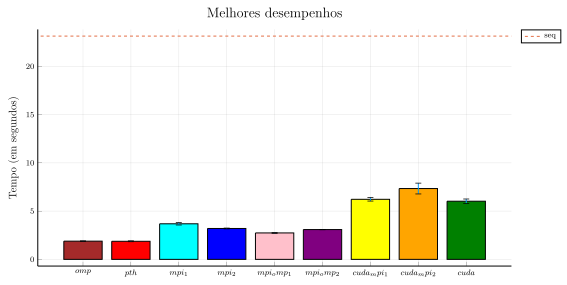

In [27]:
seq = filter(r -> "seq" != r.method, results).mean[1]
best = filter(r -> "seq" != r.method, best)
bar(best.method, best.mean, yerr = best.ci, fillcolor = reverse(colors),
    ylabel = "Tempo (em segundos)", title = "Melhores desempenhos", size=(750,400), label="")
hline!([seq], linestyle=[:dash], label="seq")

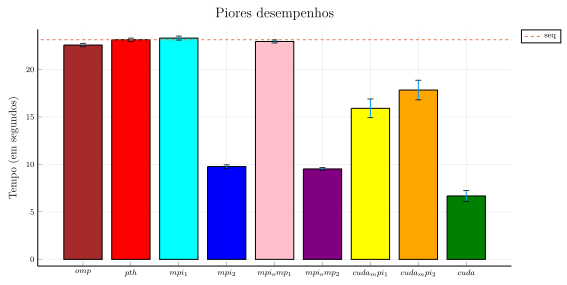

In [28]:
seq = filter(r -> "seq" != r.method, results).mean[1]
worst = filter(r -> "seq" != r.method, worst)
bar(worst.method, worst.mean, yerr = worst.ci, fillcolor = reverse(colors),
    ylabel = "Tempo (em segundos)", title = "Piores desempenhos", size=(750,400), label="")
hline!([seq], linestyle=[:dash], label="seq")

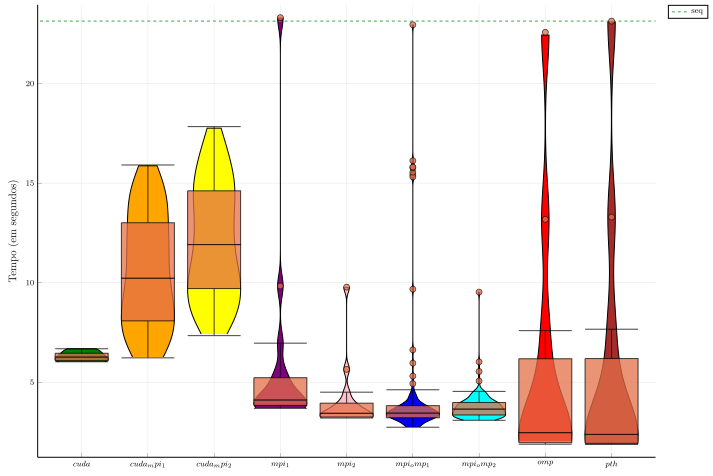

In [29]:
seq = filter(r -> "seq" != r.method, results).mean[1]
df = filter(r -> "seq" != r.method, results)
@df df violin(:method, :mean, fillcolor=colors, label="")
@df df boxplot!(:method, :mean, alpha=0.75, size=(950,700), label="", ylabel = "Tempo (em segundos)")
hline!([seq], linestyle=[:dash], label="seq")

#### Análise
A primeira coisa que notamos foi que os melhores desempenhos ocorreram com os códigos com OpenMP e Pthreads (ambos com 256 threads). Uma conjectura que formulamos para isso foi que o tamanho da imagem não era grande o suficiente para trazer benefícios com o uso de CUDA ou MPI, já que existe um grande gargalo na comunicação entre memória, processos, CPU e GPU. Isso pode explicar a desempenho ruim das execuções de CUDA com OpenMPI.

Outra coisa que vale comentar é sobre a consistência da execução em CUDA, em que o tamanho dos blocos não interfere tanto nos resultados. Por fim, notamos uma similaridade entre as diversas variações de código com OpenMPI. No entanto, vale ressaltar que a adição de um segundo nó nessas execuções interferiu mais do que a adição do OpenMP.

### Número de Threads <a class="anchor" id="experimentntreads-bullet"></a> 

O gráfico a seguir irá analisar a influência do número de threads em cada método. Para isso, serão analisados os códigos com **OpenMP**, **Pthreads** e **OpenMPI com OpenMP (1 e 2 nós)**. Para o OpenMPI, foi fixado o número de processos por em 8, sendo que na execução com dois nós, são 4 processos por nó. Vale lembrar que o eixo X aponta o número de threads por processo, e não o valor total.

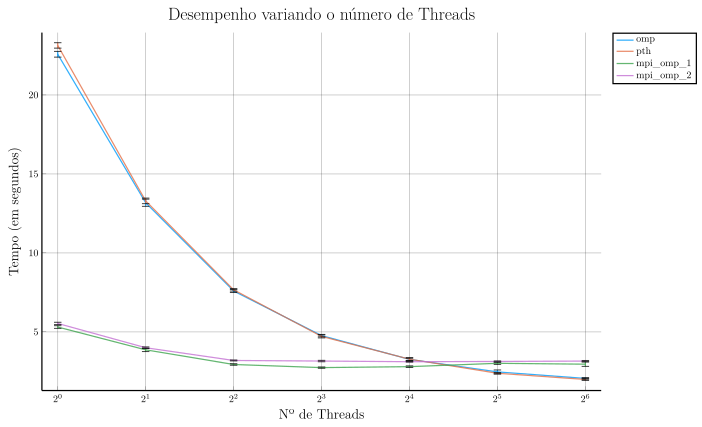

In [30]:
df1 = filter(r -> "omp" == r.method && r.threads < 65, results)
df2 = filter(r -> "pth" == r.method && r.threads < 65, results)
df3 = filter(r -> "mpi_omp_1" == r.method && r.process == 8, results)
df4 = filter(r -> "mpi_omp_2" == r.method && r.process == 8, results)
  
p = plot_results( "Desempenho variando o número de Threads",
      [df1.threads df2.threads df3.threads df4.threads], 
      [df1.mean df2.mean df3.mean df4.mean], 
      "Nº de Threads",
      ["omp" "pth" "mpi_omp_1" "mpi_omp_2"],
      [df1.ci df2.ci df3.ci df4.ci],
      0, 6)

plot(p, size=(900,600), thickness_scaling=1.25, gridalpha=0.3)

#### Análise
Quando analisamos a influência do número de threads na execução, percebemos que eles não afetam tanto o resultados dos códigos com OpenMPI. Isso pode se explicado pois o gŕafico na verdade mostra o número de threads por processo. Ou seja, para os código com OpenMPI, o número real de threads começa em 8, terminando em 512 threads, ocorrendo um overhead de threads. 

### Número de Processos<a class="anchor" id="experimentprocess-bullet"></a> 

O gráfico a seguir irá analisar a influência do número de processos em cada método. Para isso, serão analisados os códigos com **OpenMPI**, **OpenMPI com OpenMP** e **OpenMPI com CUDA** todos com 1 e 2 nós. Para o CUDA, foi fixado a dimensão do bloco em 8, e para o OpenMPI com OpenMP, foram fixadas 32 threads por processo.

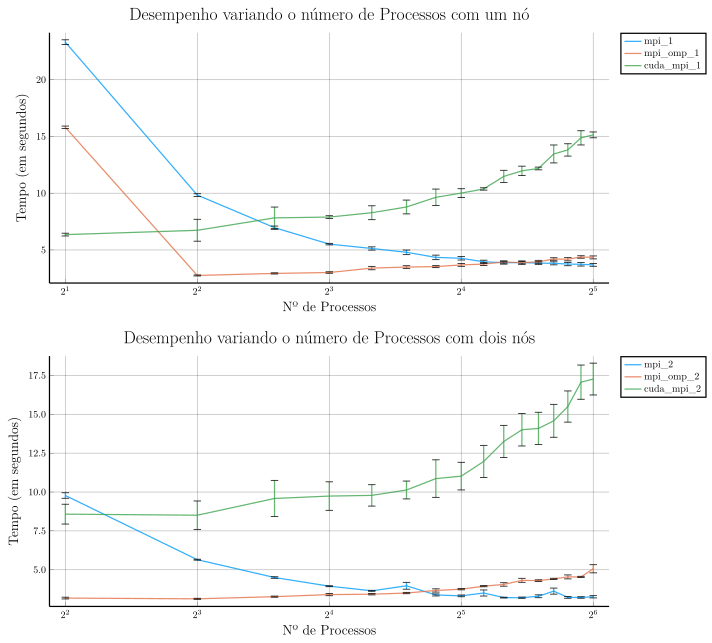

In [31]:
df1 = filter(r -> r.method == "mpi_1", results)
df2 = filter(r -> r.method == "mpi_2", results)
df3 = filter(r -> r.method == "mpi_omp_1" && r.threads == 32, results)
df4 = filter(r -> r.method == "mpi_omp_2" && r.threads == 32, results)
df5 = filter(r -> r.method == "cuda_mpi_1" && r.dimension == 8, results)
df6 = filter(r -> r.method == "cuda_mpi_2" && r.dimension == 8, results)
 
p1 = plot_results( "Desempenho variando o número de Processos com um nó",
      [df1.process df3.process df5.process], 
      [df1.mean df3.mean df5.mean], 
      "Nº de Processos",
      ["mpi_1" "mpi_omp_1" "cuda_mpi_1"],
      [df1.ci df3.ci df5.ci],
      0, 6)

p2 = plot_results( "Desempenho variando o número de Processos com dois nós",
      [df2.process df4.process df6.process], 
      [df2.mean df4.mean df6.mean], 
      "Nº de Processos",
      ["mpi_2" "mpi_omp_2" "cuda_mpi_2"],
      [df2.ci df4.ci df6.ci],
      0, 6)

plot(p1, p2, layout=(2, 1), size=(900,900), thickness_scaling=1.25, gridalpha=0.3)

#### Análise
A primeira coisa a ser notada em ambos os gráficos é o baixo desempenho do código em CUDA com OpenMPI, sendo que ao aumentar o número de processos, esses desempenho só piora. Também é possível perceber que OpenMPI com OpenMP, inicialmente, tem um desempenho superior, porém podemos perceber que o overhead no número de threads começa a afetar sua execução negativamente. Por fim, vale notar que o comportamento de ambos os gráficos é semelhante, tanto com um ou dois nós, variando apenas nos valores médios dos tempos.

### Dimensões do Bloco <a class="anchor" id="experimentdim-bullet"></a> 

O gráfico a seguir irá analisar a influência da dimensão dos blocos em cada método. Para isso, serão analisados os códigos com **CUDA** e **CUDA com OpenMPI (1 e 2 nós)**. Para o CUDA com OpenMPI, foi fixado um total de 32 processos, sendo que na execução com dois nós, são 16 processos para cada nó.

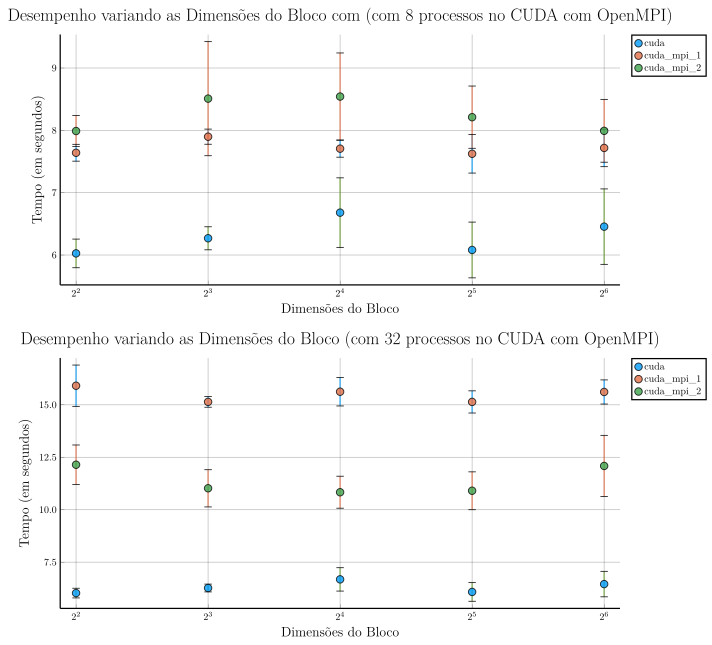

In [32]:
df1 = filter(r -> r.method == "cuda", results)
df2 = filter(r -> r.method == "cuda_mpi_1" && r.process == 8, results)
df3 = filter(r -> r.method == "cuda_mpi_2" && r.process == 8, results)
 
p1 = plot_results_log( 
      "Desempenho variando as Dimensões do Bloco com (com 8 processos no CUDA com OpenMPI)",
      [df1.dimension df2.dimension df3.dimension], 
      [df1.mean df2.mean df3.mean], 
      "Dimensões do Bloco",
      ["cuda" "cuda_mpi_1" "cuda_mpi_2"],
      [df1.ci df2.ci df3.ci],
      0, 6)

df2 = filter(r -> r.method == "cuda_mpi_1" && r.process == 32, results)
df3 = filter(r -> r.method == "cuda_mpi_2" && r.process == 32, results)

p2 = plot_results_log(
      "Desempenho variando as Dimensões do Bloco (com 32 processos no CUDA com OpenMPI)",
      [df1.dimension df2.dimension df3.dimension], 
      [df1.mean df2.mean df3.mean], 
      "Dimensões do Bloco",
      ["cuda" "cuda_mpi_1" "cuda_mpi_2"],
      [df1.ci df2.ci df3.ci],
      0, 6)

plot(p1, p2, layout=(2, 1), size=(900,900), thickness_scaling=1.25, gridalpha=0.3)

#### Análise

Analisando o gráfico acima, é possível perceber que a adição do OpenMPI afetou negativamente o desemenho do código em CUDA. Isso se agrava quando usamos apenas um nó, pois os processos têm acesso apenas a uma GPU. Nesse sentido, há uma disputa entre os processos pela GPU, causando bloqueio de recursos. Outra coisa que notamos, é que a dimensão do bloco não afeta expressivamente o desempenho. E por fim, percebe-se que o intervalo de confiança dos métodos em CUDA é maior com relação aos outros métodos, o que pode ter como causa o tempo gasto com número de pedidos de alocação de recursos da GPU e transferência entre memórias. Essa hipótese pode ser observada nos gráficos acima, onde o aumento no número de processos também prejudita no desempenho. 